# Arc Flow Formulation for the Cutting Stock Problem

This method is based on the article *Exact Solution of Bin-Packing Problems Using Column Generation and Branch-and-Bound* of *Carvalho (1999)*. We don't use the Columns Generation presented in the article, only the arc flow formulation.

In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import gurobipy as grb
from gurobipy import GRB
from collections import Counter

Our entry can be expressed by the tuple $(W, w, b)$, where:
- $W$ is the lenght of the roll;
- $w$ is the weight of the $m$ items;
- $b$ is the demand of the $m$ items.

First, we need to transform our entry in a directed graph, $G = (V,A)$, where:
- $V = \{0, 1, \dots, W\}$
- $A = \{(i,j) : 0 \leq i \leq j \leq W \quad and \quad j-i = w_d \quad \forall d \leq m \} $
- $A = A \cup (W, 0) $

In [2]:
def transform_to_graph(w, W):
    G = nx.DiGraph()
    
    for i in range(0, W):
        G.add_node(i)
    
    for i in range(0, W):
        G.add_edge(i, i+1)
        
    for j in w:
        for i in range(0, W):
            if i+j<= W:
                G.add_edge(i, i+j)
                
    G.add_edge(W, 0) 
    return G

When the entry is transformed to a directed graph, we can apply the following model. Let $x_{i,j}$ the **decision variable**, that represents the number of items of size $j-i$ placed in any bin at a distance of $j$ units from the beginning of the bin and $z$ the flow from $W$ to $0$. 

$
\min z \\
s.t.:  \sum_{(i,j) \in A} x_{ij} - \sum_{(j,k) \in A} x_{jk} = F(j) \qquad \\
     \sum_{(k,k+w_d) \in A} x_{k, k+w_d} \geq b_d \qquad \forall d = 1, 2, \dots, m \\
     x_{ij} \geq 0 \qquad \forall (i,j) \in A \\
     x_{ij} \in \mathbb{Z} \qquad \forall (i,j) \in A
$

where:
$
F(j) = \left \{ \begin{matrix} -z, & \mbox{if }j = 0 \\ z, & \mbox{if }j = W \\ 0, & \mbox{otherwise} \end{matrix} \right.
$

In [3]:
def integer_formulation_arc_flow(G, w, b, W):
    afcst = grb.Model("Arf flow formulation")
    
    #Creating the decision variables
    vars= {(u,v):afcst.addVar(vtype=grb.GRB.INTEGER,
                        name="x_{0}_{1}".format(u,v)) 
                for (u, v) in G.edges}
    
    #Objective Function (2) 
    objective = vars[W, 0]
    
    afcst.update()
    
    #First Restriction (3)
    for d in range(0, len(b)):
        afcst.addConstr(
                grb.quicksum(vars[k, k+w[d]] for k in G.nodes if (k, k+w[d]) in G.edges), ">", b[d]
            )
    
    ##Second Restriction (4)
    for j in G.nodes():
        if j == 0:
            afcst.addConstr(- grb.quicksum(vars[j, k] for k in list(G.Given any node k that is the head of another arc of size wd (wd > we) or k=0,theonlyvalidarcsforsizewe arethosethatstartatnodesk+swe,s=0,1,2,..., be – 1 and k + swe ≤ W, where be is the demand of items of size we.(j))), 
                           "=", -vars[W,0])
        elif j == W:
            afcst.addConstr(grb.quicksum(vars[i, j] for i in list(G.predecessors(j))), 
                           "=", vars[W,0])
        else: 
            afcst.addConstr(grb.quicksum(vars[i, j] for i in list(G.predecessors(j))) 
                           - grb.quicksum(vars[j, k] for k in list(G.successors(j))), 
                           "=", 0)
    
    afcst.update()            
    
    afcst.ModelSense = grb.GRB.MINIMIZE
    afcst.setObjective(objective)
    
    afcst.update()
    
    return afcst, vars

## Graph Reduction

In this article, it is presented some criterion to reduce both the symmety of the solution space and the size of the model by considering only a subset of arcs from *A*.

### Criterion 1

An arc of size $w_e$, designated by $x_{k,k+we}$, can only have its tail at a node $k$ that is the head of another arc of size $w_d$, $x_{k–wd,k}$, for $w_d \geq w_e$, or, else, from node 0, i.e., the left border of the bin.

In [83]:
def criterion_1(G, w, W):
    for k in range(W, 0, -1):
        pred_k = np.array(list(G.predecessors(k)))
        succ_k = np.array(list(G.successors(k)))
        
        max_w_k = np.max(k - pred_k)
        v_aux = succ_k-max_w_k
        
        remove_v = succ_k[v_aux>max_w_k]
        
        for i in remove_v:
            G.remove_edge(k,i)
 
    return G

### Criterion 2

All the loss arcs $x_{k,k+1}$ can be set to zero for $k < w_m$.

In [89]:
def criterion_2(G, w, W):
    w_m = w[-1]
    
    for k in range(0, w_m):
        G.remove_edge(k,k+1)
    
    return G

### Criterion 3

Given any node $k$ that is the head of another arc of size $w_d (w_d > w_e)$ or $k=0$,the only valid arcs for size $w_e$ are those that start at nodes $k+sw_e,s=0,1,2, \dots , b_e – 1$ and $k + sw_e \leq W$, where be is the demand of items of size $w_e$.

In [125]:
def criterion_3(g, w, W, b):
    for d in range(0,len(w)):
        demand = 0
        k=0
        while k <= W:
            if (k,k+w[d]) in G.edges():
                demand+=1
            if demand > b[d]:
                j=k
                while j<=W:
                    if (j, j+w[d]) in G.edges():
                        G.remove_edge(j, j+w[d])
                    j += w[d]
                    k = j
            k += w[d]
    return G

## Solution

For transform the arc flow solution into a cutting stock solution, we need:
- Create a directed weight graph with the output variables of the model;
- Find a path between 0 and W;
- Decrease 1 of all the weights in the path.

The flow in the arc $(W, 0)$ is the optimal value, the paths are the best cutting patterns and the repetition of the paths in the list of paths is the quantity of a pattern need to be applied.

In [4]:
def solution(model, W):
    weights = []
    for v in model.getVars():
        if v.x!=0:
            name = v.varName.split('_')
            (u, v, w_h) = (name[1], name[2], v.x)
            u = int(u)
            v = int(v)
            weights.append((u, v, w_h))
            
    G_final = nx.DiGraph()
    G_final.add_weighted_edges_from(weights)
    
    paths = list(nx.all_simple_paths(G_final, source=0, target=W))
    edges_path = []
    while len(paths)>0:
        path = paths[0]
        path_aux = [(path[i], path[i+1]) for i in range(0, len(path)-1)] 
        edges_path.append(path_aux)

        for (u,v) in path_aux:
            G_final[u][v]["weight"] = G_final[u][v]["weight"] - 1
            if G_final[u][v]["weight"] == 0:
                G_final.remove_edge(u,v)
        paths = list(nx.all_simple_paths(G_final, source=0, target=W))
        
    return dict(Counter(map(tuple, edges_path))), G_final[W][0]["weight"]

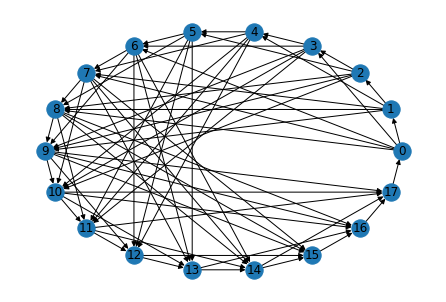

In [5]:
w = [3, 6, 7, 8]
b = [25, 20, 18, 10]
W = 17

G = transform_to_graph(w, W)

nx.draw_circular(G, with_labels= True)
plt.draw()

In [6]:
arc_flow, x = integer_formulation_arc_flow(G, w, b, W)

Academic license - for non-commercial use only - expires 2021-11-12
Using license file /Users/hismaelcosta/gurobi.lic


<ipython-input-6-260c37f16f37>:1: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  arc_flow, x = integer_formulation_arc_flow(G, w, b, W)


In [7]:
arc_flow.write("out.lp")

In [8]:
arc_flow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 22 rows, 66 columns and 180 nonzeros
Model fingerprint: 0xda67ceda
Variable types: 0 continuous, 66 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+01]
Found heuristic solution: objective 35.0000000
Presolve removed 5 rows and 7 columns
Presolve time: 0.00s
Presolved: 17 rows, 59 columns, 166 nonzeros
Variable types: 0 continuous, 59 integer (0 binary)

Root relaxation: objective 2.420000e+01, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.20000    0    5   35.00000   24.20000  30.9%     -    0s
H    0     0                      25.0000000   24.20000  3.20%     -

In [9]:
solution(arc_flow, W)

({((0, 1), (1, 2), (2, 5), (5, 8), (8, 15), (15, 16), (16, 17)): 1,
  ((0, 6), (6, 9), (9, 15), (15, 16), (16, 17)): 5,
  ((0, 6), (6, 9), (9, 17)): 10,
  ((0, 7), (7, 10), (10, 17)): 9},
 25.0)